In [14]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from PIL import Image


import os
import glob
from tqdm.notebook import tqdm

In [15]:
# !pip install easyocr

In [3]:
# !pip install --upgrade pillow

In [4]:
# !pip install fastembed-gpu

In [5]:
!pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git
!pip install gdown
!pip install easydict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.3 MB/s eta 0:00:00


## Detect shape of text

In [6]:
!git clone https://github.com/GXYM/TextBPN-Plus-Plus.git
%cd /kaggle/working/TextBPN-Plus-Plus/model
!gdown 11AtAA429JCha8AZLrp3xVURYZOcCC2s1
!unzip '/kaggle/working/TextBPN-Plus-Plus/model/Totaltext.zip'
%cd /kaggle/working/TextBPN-Plus-Plus

Cloning into 'TextBPN-Plus-Plus'...
remote: Enumerating objects: 466, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 466 (delta 99), reused 88 (delta 88), pack-reused 358 (from 1)
Receiving objects: 100% (466/466), 12.75 MiB | 16.26 MiB/s, done.
Resolving deltas: 100% (189/189), done.
/kaggle/working/TextBPN-Plus-Plus/model
Downloading...
From (original): https://drive.google.com/uc?id=11AtAA429JCha8AZLrp3xVURYZOcCC2s1
From (redirected): https://drive.google.com/uc?id=11AtAA429JCha8AZLrp3xVURYZOcCC2s1&confirm=t&uuid=577822b4-1659-45b5-9f6e-82515e38ceae
To: /kaggle/working/TextBPN-Plus-Plus/model/Totaltext.zip
100%|█████████████████████████████████████████| 349M/349M [00:01<00:00, 203MB/s]
Archive:  /kaggle/working/TextBPN-Plus-Plus/model/Totaltext.zip
   creating: Totaltext/
  inflating: Totaltext/TextBPN_deformable_resnet50_480.pth  
  inflating: Totaltext/TextBPN_resnet18_570.pth  
  inflating: Totaltext/TextBPN_re

In [7]:
input_dir = '/kaggle/input/totaltext-preprocessing/data'
extra_cfg = {
    'net': 'resnet18',
    'scale': 4,
    'exp_name': 'Totaltext',
    'checkepoch': 570,
    'test_size': [640, 960],
    'gpu': '1',
    'dis_threshold': 0.35,
    'cls_threshold': 0.9,
    'viz': True,
    'img_root': input_dir,
    'resume': None,
    'num_workers': 24,
    'cuda': False,
    'mgpu': False,
    'save_dir': './model/',
    'vis_dir': './vis/',
    'log_dir': './logs/',
    'loss': 'CrossEntropyLoss',
    'pretrain': False,
    'verbose': True,
    'max_epoch': 250,
    'lr': 1e-3,
    'lr_adjust': 'fix',
    'stepvalues': [],
    'weight_decay': 0.0,
    'gamma': 0.1,
    'momentum': 0.9,
    'batch_size': 6,
    'optim': 'Adam',
    'save_freq': 5,
    'display_freq': 10,
    'viz_freq': 50,
    'log_freq': 10000,
    'val_freq': 1000,
    'load_memory': False,
    'rescale': 255.0,
    'input_size': 640,
    'start_epoch': 0
}

In [37]:
import os
import time
import cv2
import torch
import json
from util import canvas as cav
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torch.nn.functional as F
from dataset.deploy import DeployDataset
from network.textnet import TextNet
from cfglib.config import config as cfg
from cfglib.option import BaseOptions
from util.augmentation import BaseTransform
from util.visualize import visualize_gt
from util.misc import to_device, mkdirs,rescale_result

def update_config(cfg, extra_cfg):
    for k, v in extra_cfg.items():
        cfg[k] = v
        # print(config.gpu)
        cfg.device = torch.device('cuda') if cfg.cuda else torch.device('cpu')

def osmkdir(input_pth):
    import shutil
    from pathlib import Path
    
    if os.path.isdir(input_pth):
        return input_pth
    
    input_dir = '/kaggle/working/input_dir'
    if os.path.exists(input_dir):
        try:
            shutil.rmtree(input_dir)
        except OSError as e:
            print("Error: %s - %s." % (e.filename, e.strerror))
            
    os.makedirs(input_dir)
    
    new_path = os.path.join(input_dir, Path(input_pth).name)
    shutil.copy2(input_pth, new_path)  # Use copy2 to preserve metadata
    
    # Return the path of the new folder
    return input_dir

def visualize_detection(image, output_dict, meta=None):
    image_show = image.copy()
    image_show = np.ascontiguousarray(image_show[:, :, ::-1])

    cls_preds = F.interpolate(output_dict["fy_preds"], scale_factor=cfg.scale, mode='bilinear')
    cls_preds = cls_preds[0].data.cpu().numpy()

    py_preds = output_dict["py_preds"][1:]
    init_polys = output_dict["py_preds"][0]
    shows = []

    init_py = init_polys.data.cpu().numpy()
    path = os.path.join(cfg.vis_dir, '{}_test'.format(cfg.exp_name),
                        meta['image_id'][0].split(".")[0] + "_init.png")

    im_show0 = image_show.copy()
    for i, bpts in enumerate(init_py.astype(np.int32)):
        cv2.drawContours(im_show0, [bpts.astype(np.int32)], -1, (255, 255, 0), 2)
        for j, pp in enumerate(bpts):
            if j == 0:
                cv2.circle(im_show0, (int(pp[0]), int(pp[1])), 3, (255, 0, 255), -1)
            elif j == 1:
                cv2.circle(im_show0, (int(pp[0]), int(pp[1])), 3, (0, 255, 255), -1)
            else:
                cv2.circle(im_show0, (int(pp[0]), int(pp[1])), 3, (0, 0, 255), -1)

    cv2.imwrite(path, im_show0)

    for idx, py in enumerate(py_preds):
        im_show = im_show0.copy()
        contours = py.data.cpu().numpy()
        cv2.drawContours(im_show, contours.astype(np.int32), -1, (0, 0, 255), 2)
        for ppts in contours:
            for j, pp in enumerate(ppts):
                if j == 0:
                    cv2.circle(im_show, (int(pp[0]), int(pp[1])), 3, (255, 0, 255), -1)
                elif j == 1:
                    cv2.circle(im_show, (int(pp[0]), int(pp[1])), 3, (0, 255, 255), -1)
                else:
                    cv2.circle(im_show, (int(pp[0]), int(pp[1])), 3, (0, 255, 0), -1)
        path = os.path.join(cfg.vis_dir, '{}_test'.format(cfg.exp_name),
                             meta['image_id'][0].split(".")[0] + "_{}iter.png".format(idx))
        cv2.imwrite(path, im_show)
        shows.append(im_show)

    # init_py = init_polys.data.cpu().numpy()
    # im_show_score = image_show.copy()
    # for in_py in init_py:
    #     mask = np.zeros_like(cls_preds[0], dtype=np.uint8)
    #     cv2.drawContours(mask, [in_py.astype(np.int32)], -1, (1,), -1)
    #     score = cls_preds[0][mask > 0].mean()
    #     if score > 0.9:
    #         cv2.drawContours(im_show_score, [in_py.astype(np.int32)], -1, (0, 255, 0), 2)
    #     else:
    #         cv2.drawContours(im_show_score, [in_py.astype(np.int32)], -1, (255, 0, 255), 2)
    #     cv2.putText(im_show_score, "{:.2f}".format(score),
    #                 (int(np.mean(in_py[:, 0])), int(np.mean(in_py[:, 1]))), 1, 1, (0, 255, 255), 2)
    #     print(score)

    # path = os.path.join(cfg.vis_dir, '{}_test'.format(cfg.exp_name),
    #                     meta['image_id'][0].split(".")[0] + "init.png")
    # cv2.imwrite(path, im_show_score)

    show_img = np.concatenate(shows, axis=1)
    show_boundary = cv2.resize(show_img, (320 * len(py_preds), 320))

    # fig = plt.figure(figsize=(5, 4))
    # ax1 = fig.add_subplot(111)
    # # ax1.set_title('distance_field')
    # ax1.set_autoscale_on(True)
    # im1 = ax1.imshow(cls_preds[0], cmap=cm.jet)
    # plt.colorbar(im1, shrink=0.75)
    # plt.axis("off")
    # path = os.path.join(cfg.vis_dir, '{}_test'.format(cfg.exp_name),
    #                     meta['image_id'][0].split(".")[0] + "_cls.png")
    # plt.savefig(path, dpi=300)
    # plt.close(fig)
    #
    # fig = plt.figure(figsize=(5, 4))
    # ax1 = fig.add_subplot(111)
    # # ax1.set_title('distance_field')
    # ax1.set_autoscale_on(True)
    # im1 = ax1.imshow(np.array(cls_preds[1] / np.max(cls_preds[1])), cmap=cm.jet)
    # plt.colorbar(im1, shrink=0.75)
    # plt.axis("off")
    # path = os.path.join(cfg.vis_dir, '{}_test'.format(cfg.exp_name),
    #                     meta['image_id'][0].split(".")[0] + "_dis.png")
    # plt.savefig(path, dpi=300)
    # plt.close(fig)

    cls_pred = cav.heatmap(np.array(cls_preds[0] * 255, dtype=np.uint8))
    dis_pred = cav.heatmap(np.array(cls_preds[1] * 255, dtype=np.uint8))

#     heat_map = np.concatenate([cls_pred*255, dis_pred*255], axis=1)
    heat_map = cls_pred*255
    heat_map = cv2.resize(heat_map, (320, 320))

    return show_boundary, heat_map

def heatmap_to_binary(heatmap, threshold=127):
    heatmap_binary = np.where(heatmap[:,:, 0] >= threshold, 255, 0)
    
    return heatmap_binary

def inference(model, test_loader):

    total_time = 0.
    art_results = {}
    for i, (image, meta) in enumerate(test_loader):
        input_dict = dict()
        idx = 0  # test mode can only run with batch_size == 1
        H, W = meta['Height'][idx].item(), meta['Width'][idx].item()
        print(meta['image_id'], (H, W))

        input_dict['img'] = to_device(image)
        # get detection result
        start = time.time()
        output_dict = model(input_dict)
#         print(output_dict["py_preds"])
        torch.cuda.synchronize()
        end = time.time()
        if i > 0:
            total_time += end - start
            fps = (i + 1) / total_time
        else:
            fps = 0.0

        print('detect {} / {} images: {}. ({:.2f} fps)'.
              format(i + 1, len(test_loader), meta['image_id'][idx], fps))

        # visualization
        img_show = image[idx].permute(1, 2, 0).cpu().numpy()
        img_show = ((img_show * cfg.stds + cfg.means) * 255).astype(np.uint8)
        gt_contour = []
        label_tag = meta['label_tag'][idx].int().cpu().numpy()
        for annot, n_annot in zip(meta['annotation'][idx], meta['n_annotation'][idx]):
            if n_annot.item() > 0:
                gt_contour.append(annot[:n_annot].int().cpu().numpy())

        gt_vis = visualize_gt(img_show, gt_contour, label_tag)
        show_boundary, heat_map = visualize_detection(img_show, output_dict, meta=meta)
#             file_path = os.path.join(cfg.vis_dir, meta['image_id'][idx].split(".")[0]+"_heat_map.json")
        np.set_printoptions(threshold=np.inf)
#             print(heat_map[:,:, 0])
        heatmap_binary = heatmap_to_binary(heat_map)
#         plt.imshow(heatmap_binary)
#         plt.show()
        show_map = np.concatenate([heat_map, gt_vis], axis=1)
        show_map = cv2.resize(show_map, (320 * 3, 320))
        im_vis = np.concatenate([show_map, show_boundary], axis=0)

        contours = output_dict["py_preds"][-1].int().cpu().numpy()
        img_show, contours = rescale_result(img_show, contours, H, W)
        print('heatmap shape before resize', heatmap_binary.shape)
        
        heatmap_binary = cv2.resize(heatmap_binary.astype(float), (img_show.shape[1], img_show.shape[0]))
        image_text = np.zeros_like(img_show)
    
        for i in range(3):
            image_text[:, :, i] = np.where(heatmap_binary < 127, img_show[:, :, i], 0)
            
        
#         print('image text shape', image_text.shape)
#         print('heatmap shape', heatmap_binary.shape)
        result = {
            'heatmap': heatmap_binary,
            'contours': contours,
            'image_region': image_text
        }
#         print(result.keys())
        art_results[meta['image_id'][0]] = result
        
    return art_results

def extract_shape_text(input_pth):
#     if not os.path.isdir(input_pth):
        
    extra_cfg['img_root'] = osmkdir(input_pth)
    update_config(cfg, extra_cfg)
    testset = DeployDataset(
        image_root=cfg.img_root,
        transform=BaseTransform(size=cfg.test_size, mean=cfg.means, std=cfg.stds)
    )

    if cfg.cuda:
        cudnn.benchmark = True

    # Data
    test_loader = data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=cfg.num_workers)

    # Model
    model = TextNet(is_training=False, backbone=cfg.net)
    model_path = os.path.join(cfg.save_dir, cfg.exp_name,
                              'TextBPN_{}_{}.pth'.format(model.backbone_name, cfg.checkepoch))

    model.load_model(model_path)
    model = model.to(cfg.device)  # copy to cuda
    model.eval()
    with torch.no_grad():
        print('Start testing TextBPN++.')
        return inference(model, test_loader)



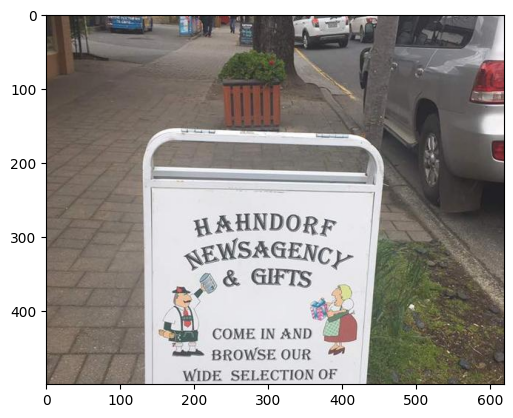

Loading from ./model/Totaltext/TextBPN_resnet18_570.pth
Start testing TextBPN++.
['img1005.jpg'] (500, 619)
detect 1 / 1 images: img1005.jpg. (0.00 fps)
heatmap shape before resize (320, 320)
image text shape (500, 619, 3)
heatmap shape (500, 619)


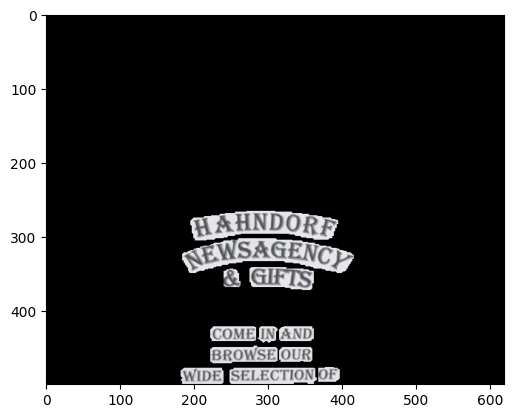

In [44]:
image_path = '/kaggle/input/totaltextstr/Total-Text/Train/img1005.jpg'
image = Image.open(image_path)
plt.imshow(image)
plt.show()

results = extract_shape_text(image_path)
# results = {
# image: {heat_map, contours}
# }
img = results['img1005.jpg']['image_region']
plt.imshow(img)
plt.show()

In [ ]:
from torchvision import transforms

# Define any transformations for the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(10),      # Randomly rotate the image by up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop the image and resize it to 224x224
    transforms.ToTensor(),
    transforms.Grayscale(3)  # Normalize using ImageNet statistics
])

In [ ]:
import timm
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import clip
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Step 1: Load and Modify the Model
classes = ['serif', 'sans_serif', 'script', 'serif monospaced', 
           'serif display', 'sans_serif monospaced', 'sans_serif display', 
           'script display', 'serif monospaced display', 'sans_serif monospaced display']
num_classes = len(classes)
model_for_embeddings, preprocess = clip.load("ViT-B/32", device=device)

def get_style_embedding(image_path):
    image = Image.open(image_path)
    input_image = preprocess(image).unsqueeze(0)
    input_tensor = input_image.to(device)
    with torch.no_grad():
        embedding = model_for_embeddings.encode_image(input_tensor)
        return embedding

In [ ]:
# from fastembed import TextEmbedding
from typing import List
# text_model = TextEmbedding(model_name="BAAI/bge-small-en-v1.5")
# from fastembed import ImageEmbedding
image_model = model_for_embeddings.encode_image

In [ ]:
import easyocr
import cv2

def create_mask(image_path, bboxes):
    # Read the image to get its dimensions
    img = cv2.imread(image_path)
    height,width,_ = img.shape

    # Create a blank mask with the same dimensions as the image
    mask = np.zeros((height, width), dtype=np.uint8)

    # Draw the bounding box on the mask
    # bbox format: ((x1, y1), (x2, y2))
    for bbox in bboxes:
        bbox_tuples = [(coord[0], coord[1]) for coord in bbox]
        # Draw the polygon (bounding box) on the mask
        cv2.fillPoly(mask, np.array([bbox_tuples], dtype=np.int32), color=255) # -1 fills the rectangle

    # Save the mask as an image
#     print(mask.shape)
#     print(img.shape)
#     plt.imshow(mask)
#     plt.show()
    
    masked_img = cv2.bitwise_and(img, img, mask=mask)
#     print(masked_img.shape,type(masked_img))
#     print(masked_img)
#     plt.imshow(masked_img)
#     plt.show()

    return masked_img
def extract_text(image_path):
#     print(image_path)
    reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory
    result = reader.readtext(image_path)
    texts = ""
    b_boxes = []
    for line in result:
        b_boxes.append(line[0])
        texts +=" " +line[1]
    masked_img = create_mask(image_path, b_boxes)
#     print(masked_img,texts)
    return masked_img,texts

In [ ]:
# from fastembed import TextEmbedding
from typing import List
def read_image(path,to_float=False):
    img = Image.open(path)
    return img

def generate_features(image_path):
    img , text = extract_text(str(image_path))
    documents: List[str] = [text]
    embeddings_list = list(text_model.embed(documents))
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.imshow(img)
    plt.show()
    temp_image_path = 'temp_image.jpeg'
    img.save(temp_image_path)
    
    # Extract visual features using FastEmbed
    
    visual_feature = get_style_embedding(temo_image_path)
    
    # Optionally delete the temporary image file
    os.remove(temp_image_path)
#     print(visual_feature.shape)
    return visual_feature,embeddings_list[0]

In [ ]:
base_image_path = '/kaggle/input/totaltextstr/Total-Text/Train'
feature_paths = glob.glob('/kaggle/input/embedding/annotation/*')
# feature_paths

In [ ]:

# import os
# from tqdm import tqdm

# # Example list of filenames  # Replace with your actual filenames

# # Example list of documents (contents read from files)
# documents: List[str] = []
# for file_name in text_fea_paths:
#     with open(file_name, 'r', encoding='utf-8') as file:
#         documents.append(file.read())

# # Initialize the TextEmbedding model
# embedding_model = TextEmbedding()
# print("The model BAAI/bge-small-en-v1.5 is ready to use.")

# # Embedding each document and storing embeddings with filenames
# embeddings_with_filenames = []
# for i, embedding in tqdm(enumerate(embedding_model.embed(documents))):
#     embedding_filename = f"{os.path.basename(text_fea_paths[i])}_embedding.npy"
    
#     # Save the embedding to a .npy file
#     np.save(embedding_filename, embedding)
    
#     embeddings_with_filenames.append((os.path.basename(text_fea_paths[i]), embedding))

# # Example of accessing the first document's embedding and filename
# first_filename, first_embedding = embeddings_with_filenames[0]
# print(f"Filename: {first_filename}")
# print(f"Embedding vector shape: {first_embedding.shape}")

# # Now embeddings_with_filenames contains tuples of (filename, embedding_vector)
# # You can process or store these embeddings as needed


In [ ]:
# print(first_filename, first_embedding)

In [ ]:
from scipy.spatial import distance
from scipy.stats import wasserstein_distance
import json
def safe_log(x):
    return np.log(np.clip(x, a_min=1e-10, a_max=None))  # Clip values to avoid log(0)

def calculate_sid(q, p):
    # Replace NaN and Inf values with finite numbers
    q = np.nan_to_num(q, nan=1e-10, posinf=1e-10, neginf=1e-10)
    p = np.nan_to_num(p, nan=1e-10, posinf=1e-10, neginf=1e-10)
    
    # Avoid division by zero by adding a small epsilon value
    epsilon = 1e-10
    q = q + epsilon
    p = p + epsilon
    
    # Calculate SID
    sid_qp = np.sum(q * safe_log(q / p))
    sid_pq = np.sum(p * safe_log(p / q))
    return sid_qp, sid_pq
def wassernstein_dis(a,b):
    a = np.squeeze(a)
    b = np.squeeze(b)
    return -wasserstein_distance(a,b)
def city_block(a,b):
    a = np.squeeze(a)
    b = np.squeeze(b)
    return -distance.cityblock(a,b)
    
def cosine_similarity(vector_a, vector_b):
    vector_a = np.squeeze(vector_a)
    vector_b = np.squeeze(vector_b)
    dot_product = np.dot(vector_a, vector_b)
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

#get_similarities = np.vectorize(get_similarity, signature='(n), (k) -> ()')

def get_similarity(image_path,feature_paths):
    sim = []
    embedding = get_style_embedding(image_path)
    for path in feature_paths:
#         print(path)
        with open(path, 'r', encoding='utf-8') as f:
                feature = json.load(f)
        sim.append( {
            'id': feature['image_id'] + "." +str(feature['box_id']),
            'style_sim': city_block(embedding.cpu(),feature['style_embedding'])
        })
    return sorted(sim, key=lambda x: x['style_sim'], reverse=True)
    
def merge_retrieved_lists(list1, relevance_scores1, list2, relevance_scores2, asc=True):
    # Combine the lists and relevance scores into tuples
    list1 = get_result_path(list1, vis_fea_paths)
    list2 = get_result_path(list2, text_fea_paths)
    combined_list1 = list(zip(list1, relevance_scores1))
    combined_list2 = list(zip(list2, relevance_scores2))

    # Create a dictionary to keep the product of relevance scores for each document
    relevance_dict = {}

    # Combine both lists and compute the product of relevance scores
    for doc_id, score in combined_list1:
        if doc_id in relevance_dict:
            relevance_dict[doc_id] *= score
        else:
            relevance_dict[doc_id] = score

    for doc_id, score in combined_list2:
        if doc_id in relevance_dict:
            relevance_dict[doc_id] *= score
        else:
            relevance_dict[doc_id] = score

    # Sort the dictionary items by relevance score in ascending or descending order
    sorted_docs = sorted(relevance_dict.items(), key=lambda item: item[1],reverse = asc)

    # Extract the document IDs from the sorted list
    final_list = [doc_id for doc_id, score in sorted_docs]

    return final_list


def get_results(vis_paths,text_paths):
    vis_list = get_result_path(vis_paths,vis_fea_paths)
    text_list = get_result_path(text_paths,text_fea_paths)
    print(vis_list[:10],text_list[:10])
    intersection = list(set(vis_list) & set(text_list))
    return intersection
def get_result_path(indexes,feature_paths):
    res_list = []
    for item in indexes:
#         print(len(feature_paths))
#         print(item)
        feature_path = feature_paths[item]
        image_name = os.path.basename(feature_path)
        image_name = image_name.split(".")[0] + "."
#         print(image_name)
        image_path = [image_path for image_path in image_paths if image_name in image_path]
#         print(image_path)
        res_list.append(image_path[0])
    return res_list
def plot_10_images(indexes,feature_paths=None):
    similar_image_paths = indexes
    if feature_paths != None:
        similar_image_paths = get_result_path(indexes,feature_paths)
    print('Top 10 Similar Images:')    
    _, _ = plt.subplots(2, 5, figsize = (50, 20))
    for i, image_path in enumerate(similar_image_paths[:10]):
        plt.subplot(2, 5, i+1)
        img = read_image(image_path)
        plt.title(os.path.basename(image_path))
        plt.imshow(img)
    plt.show()    

In [ ]:
# ls ../input/feature-database/img.jpg


In [ ]:
import os

file_path = '/kaggle/input/totaltextstr/Total-Text/Test/img1.jpg'
if os.path.exists(file_path):
    print("File exists.")
else:
    print("File does not exist or path is incorrect.")


In [ ]:
import matplotlib.pyplot as plt
import cv2
def visualize_results(results, base_path):
    # Limit to the first 5 results
    top_results = results[:5]
    
    plt.figure(figsize=(15, 5))  # Set the figure size for better visibility
    
    for i, result in enumerate(top_results):
        image_path = f"{base_path}/{result['id']}.jpg"  # Create the image path
        img = Image.open(image_path)  # Open the image
        
        # Plot the image
        plt.subplot(1, 5, i + 1)  # Create a subplot for each image (1 row, 5 columns)
        plt.imshow(img)
        plt.title(f"Result {i+1}")
        plt.axis('off')  # Hide axis
        
    plt.show()
    
# Path to the sample image
sample_image_path = '/kaggle/input/totaltext-preprocessing/data/img102.0.jpg'

# Read the image using cv2
sample_image = Image.open(sample_image_path)
results = get_similarity(sample_image_path,feature_paths)
visualize_results(results,'/kaggle/input/totaltext-preprocessing/data')
# Display the image using matplotlib
plt.title('Query Image')
plt.imshow(sample_image)
plt.axis('off')  # Hide the axis
plt.show()

# Generate features for the sample image

# Plot the top 10 images using their indexes and paths
# print("Style results")
# plot_10_images(vis_indexes, vis_fea_paths)
# text_sim, text_indexes = get_text_results(text_fea, text_fea_paths)
# indexes = merge_retrieved_lists(vis_indexes,vis_sim,text_indexes,text_sim)
# # Plot the top 10 images using their indexes and paths
# print("Text results:")
# plot_10_images(text_indexes, text_fea_paths)
# print("Combined results:")
# plot_10_images(indexes, None)

